<a href="https://colab.research.google.com/github/ahmadSultan-12/ML-Course/blob/main/Fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing required packages and libraries...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, accuracy_score
from keras.models import Model, load_model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Flatten
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical

import pickle
%matplotlib inline
print('All packages have been imported successfully')

All packages have been imported successfully


In [ ]:
# visualizing data
data = pd.read_csv('/content/drive/MyDrive/fake_news_detection_dataset/1569488175_train.csv')
data.head()


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
# grouping input data and target labels
data['News'] = data['title'] + data['text']
data_final = data[['News','label']]
data_final.head()


,News,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",0
2,Why the Truth Might Get You FiredWhy the Truth...,1
3,15 Civilians Killed In Single US Airstrike Hav...,1
4,Iranian woman jailed for fictional unpublished...,1


In [ ]:
# data cleaning
data_final.isna().sum() # checking for missing values




News     597
label      0
dtype: int64

In [ ]:
data_final.dropna(inplace=True) # remove rows having missing values
data_final.isna().sum() # checking for missing values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


News     0
label    0
dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Fake vs Real News')

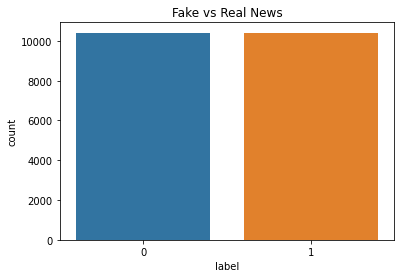

In [ ]:
# checking dataset size and balancing...
ax = sns.countplot(data_final.label)
ax.tick_params(axis='both')
#plt.xlabel('Label', color = 'white')
#plt.ylabel('count', color = 'white')
plt.title('Fake vs Real News')


In [ ]:
len(data_final.index)

20203

In [ ]:
# separating input and output data variables
X = data_final.News
Y = data_final.label


In [ ]:
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [ ]:
Y.shape

(20203, 1)

In [ ]:
# splitting dataset into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,
                                                   test_size=0.15, shuffle = 'True')

In [ ]:
X_train[1]

'FLYNN: Hillary Clinton, Big Woman on Campus - BreitbartEver get the feeling your life circles the roundabout rather than heads in a straight line toward the intended destination? [Hillary Clinton remains the big woman on campus in leafy, liberal Wellesley, Massachusetts. Everywhere else votes her most likely to don her inauguration dress for the remainder of her days the way Miss Havisham forever wore that wedding dress.  Speaking of Great Expectations, Hillary Rodham overflowed with them 48 years ago when she first addressed a Wellesley graduating class. The president of the college informed those gathered in 1969 that the students needed “no debate so far as I could ascertain as to who their spokesman was to be” (kind of the like the Democratic primaries in 2016 minus the   terms unknown then even at a Seven Sisters school). “I am very glad that Miss Adams made it clear that what I am speaking for today is all of us —  the 400 of us,” Miss Rodham told her classmates. After appointin

In [ ]:
Y_train[1]

array([0])

In [ ]:
# text cleaning(punctuations, stop words, special characters, etc.) and vectorizing
max_words = 1000 # dictionary size
max_len = 150   # no.of words in one news 
tok = Tokenizer(num_words = max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences, 
                                           maxlen=max_len)



TypeError: ignored

In [ ]:
sequences_matrix[1]


array([102, 308,  39,  25, 234, 634,  38, 277, 102,  51, 465, 504, 530,
         4,   1, 140,  74,  25, 112, 465, 115,   5,   4,  31, 573, 465,
       115,   5,  11,  19,  44, 817,   2,   9, 688, 529,  39,   1, 785,
         7, 612, 483, 209, 139,   6,   1, 196,  42, 485,  29,   4, 179,
         8,   5,   2,   1,  48,  95,   4,  20, 330,  10,   4, 572,  16,
        62,  22,  20,  27, 287,   8, 112,  25,  34, 204,   2, 771,  14,
       934,  70, 607, 229, 109,   5, 607,  34,   9,   1,  20,   1,  48,
        95,  41,  70,   4,  39,  30,   6, 263,   2,   5, 779,   9,  70,
        41,  21,   5, 226,   9,  10,  55,  88, 344, 219,  24, 388,  70,
       229,  14,  42,  22,  65,  38,  65, 344, 748,   6, 357,  88, 748,
        10,  12,   1, 408,  55,  34,   2, 607,  10, 170,  34, 118,   9,
         5, 408,   4,  38, 508,   5,  60], dtype=int32)

In [ ]:
# model building... LSTM
def fake_news_detector_LSTM():
    inputs = Input(name='inputs', shape = [max_len])
    layer = Embedding(max_words, 50, input_length = max_len)(inputs) # no.of features = 50
    layer = LSTM(64)(layer)
    layer = Dense(256, name = 'FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1, name = 'out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [ ]:
LSTM_model = fake_news_detector()
LSTM_model.summary()
LSTM_model.compile(loss='binary_crossentropy', 
              optimizer = RMSprop(), 
              metrics = ['accuracy'])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_4 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

In [ ]:
train_val_history = LSTM_model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
                              validation_split=0.2)

Epoch 1/10
108/108 [==============================] - 22s 188ms/step - loss: 0.4934 - accuracy: 0.7545 - val_loss: 0.2138 - val_accuracy: 0.9191
Epoch 2/10
108/108 [==============================] - 20s 183ms/step - loss: 0.2338 - accuracy: 0.9109 - val_loss: 0.2202 - val_accuracy: 0.9153
Epoch 3/10
108/108 [==============================] - 20s 185ms/step - loss: 0.1992 - accuracy: 0.9245 - val_loss: 0.2250 - val_accuracy: 0.9159
Epoch 4/10
108/108 [==============================] - 20s 184ms/step - loss: 0.1769 - accuracy: 0.9347 - val_loss: 0.2076 - val_accuracy: 0.9258
Epoch 5/10
108/108 [==============================] - 20s 182ms/step - loss: 0.1642 - accuracy: 0.9360 - val_loss: 0.2028 - val_accuracy: 0.9205
Epoch 6/10
108/108 [==============================] - 20s 183ms/step - loss: 0.1558 - accuracy: 0.9438 - val_loss: 0.5163 - val_accuracy: 0.8675
Epoch 7/10
108/108 [==============================] - 20s 184ms/step - loss: 0.1570 - accuracy: 0.9448 - val_loss: 0.2040 - val_ac

In [ ]:
# Save Training and Validation History in a Dictionary....
with open('/content/drive/My Drive/fake_news_detection_LSTM_history', 'wb') as f:
  pickle.dump(train_val_history.history, f)

# save model to disk for later use...
LSTM_model.save("/content/drive/My Drive/fake_news_detection_LSTM_model.h5")


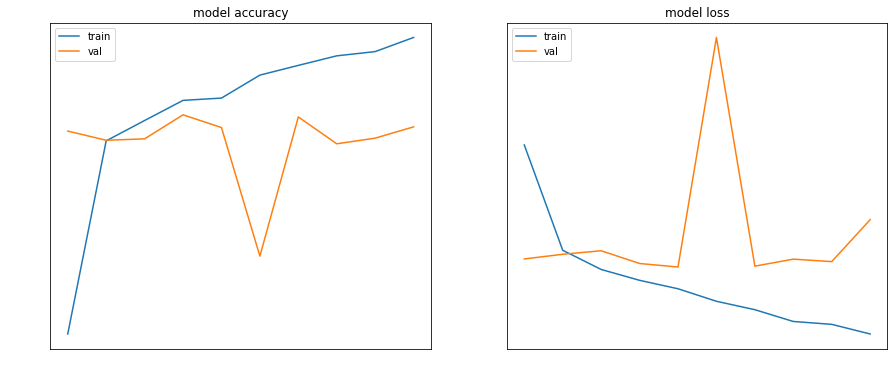

In [ ]:
## Step6:   "Plotting Training and Validation History"

with open('/content/drive/My Drive/fake_news_detection_LSTM_history', 'rb') as f:
    # load using pickle de-serializer
    history = pickle.load(f)

plt.figure(figsize=(15, 6))

# plot model accuracies...
ax = plt.subplot(1, 2, 1) 
ax.tick_params(axis='both', colors='white')
plt.plot(history["accuracy"])
plt.plot(history["val_accuracy"])
plt.title('model accuracy')
plt.ylabel("accuracy", color = 'white')
plt.xlabel("epoch", color = 'white')
plt.legend(['train', 'val'], loc = 'upper left')

# plot model losses...
ax = plt.subplot(1, 2, 2) # loss
ax.tick_params(axis='both', colors='white')
plt.plot(history["loss"])
plt.plot(history["val_loss"])
plt.title('model loss')
plt.ylabel("loss", color = 'white')
plt.xlabel("epoch", color = 'white')
plt.legend(['train', 'val'], loc = 'upper left')

plt.show()

In [ ]:
# testing
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,
                                               maxlen = max_len)


model = load_model("/content/drive/My Drive/fake_news_detection_LSTM_model.h5")  

accr= model.evaluate(test_sequences_matrix,Y_test)
print("Test set \n Loss : {:0.3f} \n Accuracy: {:0.3f}".format(accr[0],accr[1]))
# assuming test batch size to be 32

95/95 [==============================] - 2s 19ms/step - loss: 0.2524 - accuracy: 0.9215
Test set 
 Loss : 0.252 
 Accuracy: 0.921


In [ ]:
# model building... ANN
def fake_news_detector_ANN():
    model = Sequential(
        [Input(shape = (max_len)),
         Embedding(max_words, 50, input_length = max_len), # depth = 50
         Flatten(), # 3D to 2D
         Dense(256, activation='relu'),
         Dropout(0.4),
         Dense(64, activation='relu'),
         Dense(1, activation='sigmoid')  # Binary Classification
    ])

    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model

ANN_model = fake_news_detector_ANN() # create a model instance...
ANN_model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
flatten_3 (Flatten)          (None, 7500)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               1920256   
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 1,986,769
Trainable params: 1,986,769
Non-trainable params: 0
____________________________________________

In [ ]:
train_val_history = ANN_model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
                              validation_split=0.2)

Epoch 1/10
108/108 [==============================] - 6s 53ms/step - loss: 0.4818 - acc: 0.7445 - val_loss: 0.2087 - val_acc: 0.9202
Epoch 2/10
108/108 [==============================] - 6s 52ms/step - loss: 0.0981 - acc: 0.9675 - val_loss: 0.2245 - val_acc: 0.9170
Epoch 3/10
108/108 [==============================] - 6s 51ms/step - loss: 0.0255 - acc: 0.9928 - val_loss: 0.3141 - val_acc: 0.9156
Epoch 4/10
108/108 [==============================] - 6s 52ms/step - loss: 0.0103 - acc: 0.9964 - val_loss: 0.3629 - val_acc: 0.9141
Epoch 5/10
108/108 [==============================] - 6s 53ms/step - loss: 0.0039 - acc: 0.9991 - val_loss: 0.4349 - val_acc: 0.9080
Epoch 6/10
108/108 [==============================] - 6s 53ms/step - loss: 0.0016 - acc: 0.9997 - val_loss: 0.4531 - val_acc: 0.9106
Epoch 7/10
108/108 [==============================] - 6s 51ms/step - loss: 6.0835e-04 - acc: 0.9999 - val_loss: 0.4912 - val_acc: 0.9086
Epoch 8/10
108/108 [==============================] - 6s 52ms/ste

In [ ]:
# testing
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,
                                               maxlen = max_len)


# model = load_model("/content/drive/My Drive/fake_news_detection_LSTM_model.h5")  

accr= ANN_model.evaluate(test_sequences_matrix,Y_test)
print("Test set \n Loss : {:0.3f} \n Accuracy: {:0.3f}".format(accr[0],accr[1]))
# assuming test batch size to be 32

95/95 [==============================] - 0s 5ms/step - loss: 0.5999 - acc: 0.9126
Test set 
 Loss : 0.600 
 Accuracy: 0.913


In [ ]:
# feature extraction for NB
vectorizer = TfidfVectorizer()
vectorizer.fit_transform(X_train)



<17172x176044 sparse matrix of type '<class 'numpy.float64'>'
	with 5883214 stored elements in Compressed Sparse Row format>

In [ ]:
# model building... NB
NB = MultinomialNB()
NB.fit(vectorizer.transform(X_train), Y_train)
Y_pred_NB = NB.predict(vectorizer.transform(X_test))

In [ ]:
confusion_matrix(Y_test, Y_pred_NB)

array([[1427,   97],
       [ 233, 1274]])

In [ ]:
accuracy_score(Y_test, Y_pred_NB)

0.9056417024084461

In [ ]:
# feature extraction for SVM
vectorizer = TfidfVectorizer(max_features=10000)
vectorizer.fit_transform(X_train)

<17172x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 5040654 stored elements in Compressed Sparse Row format>

In [ ]:
# model building... SVM
SVM = SVC()
SVM.fit(vectorizer.transform(X_train), Y_train)
Y_pred_SVM = SVM.predict(vectorizer.transform(X_test))

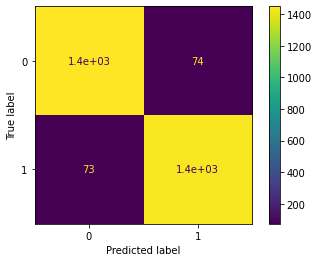

In [ ]:
plot_confusion_matrix(SVM, vectorizer.transform(X_test), Y_test)

In [ ]:
accuracy_score(Y_test, Y_pred_SVM)

0.9620587264929066

In [ ]:
confusion_matrix(Y_test, Y_pred_SVM)

array([[1450,   74],
       [  73, 1434]])